In [54]:
from steely import DATA_TASK_1_DIR, ROOT_DIR

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

from scipy.signal import welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import json

nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

train_df = pl.read_ndjson(DATA_TASK_1_DIR / "train.jsonl")
val_df = pl.read_ndjson(DATA_TASK_1_DIR / "val.jsonl")

with open(ROOT_DIR / "tmp" / "word_correlations.json", "r") as f:
    word_correlations = json.load(f)

labels = {
    0: "Human",
    1: "AI"
}

len(train_df), len(val_df), len(word_correlations)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(23707, 3589, 57073)

In [ ]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))          # O(1) look-ups

def stem_tokenise(text: str) -> list[str]:
    """Lower-case, tokenise, remove punctuation & stop-words, then stem."""
    tokens = [t for t in word_tokenize(text.lower())
              if t.isalpha()]  # and t not in stop_words]
    return [stemmer.stem(t) for t in tokens]

def get_signal(text: str) -> float:
    """Get the signal of a text."""
    tokens = stem_tokenise(text)
    return [word_correlations[token] for token in tokens if token in word_correlations]

def plot_signal(signal: list[float], smoothing_factor: float = None) -> None:
    """Plot the signal values with optional smoothing."""
    if smoothing_factor:
        smoothed_signal = []
        for i in range(len(signal)):
            start = max(0, i - int(smoothing_factor))
            end = min(len(signal), i + int(smoothing_factor) + 1)
            smoothed_signal.append(np.mean(signal[start:end]))
        signal = smoothed_signal

    plt.figure(figsize=(10, 5))
    plt.plot(signal, linestyle='-', color='b')
    plt.xlabel("Index")
    plt.ylabel("Signal Value")
    plt.grid(True)
    plt.show()
    
def plot_periodogram(frequencies: list[float], power_density: list[float]) -> None:
    """Plot the periodogram of a signal."""
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, power_density, linestyle='-', color='r')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True)
    plt.show()

def plot_ai_vs_human(mean_human_power_density: list[float], mean_ai_power_density: list[float], 
                     frequencies: list[float], std_human: list[float] = None, std_ai: list[float] = None, 
                     begin: int = None, end: int = None) -> None:
    """Plot the mean power density spectrum for AI vs Human with standard deviation bands."""
    plt.figure(figsize=(10, 5))
    
    if begin and end:
        mean_human_power_density = mean_human_power_density[begin:end]
        mean_ai_power_density = mean_ai_power_density[begin:end]
        frequencies = frequencies[begin:end]
        if std_human is not None:
            std_human = std_human[begin:end]
        if std_ai is not None:
            std_ai = std_ai[begin:end]
        
    # Plot mean power density
    plt.plot(frequencies, mean_human_power_density, label="Human Mean", color="blue")
    plt.plot(frequencies, mean_ai_power_density, label="AI Mean", color="red")
    
    # Add standard deviation bands
    if std_human is not None:
        plt.fill_between(frequencies, 
                         np.array(mean_human_power_density) - np.array(std_human), 
                         np.array(mean_human_power_density) + np.array(std_human), 
                         color="blue", alpha=0.2, label="Human Std Dev")
    if std_ai is not None:
        plt.fill_between(frequencies, 
                         np.array(mean_ai_power_density) - np.array(std_ai), 
                         np.array(mean_ai_power_density) + np.array(std_ai), 
                         color="red", alpha=0.2, label="AI Std Dev")
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Mean Power Density")
    plt.title("Mean Power Density Spectrum: Human vs AI")
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_periodogram(signal: list[float], fs: float = 1.0, nperseg: int = 256, nfft: int = 1024) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the periodogram of a signal using Welch's method with normalization.

    Parameters:
        signal (list[float]): The input signal.
        fs (float): Sampling frequency of the signal. Default is 1.0.
        nperseg (int): Length of each segment for Welch's method. Adjusted to signal length.

    Returns:
        tuple[np.ndarray, np.ndarray]: Frequencies and power spectral density.
    """
    signal = np.asarray(signal)
    signal = signal / np.std(signal)  # norm amplitude
    
    nperseg = min(nperseg, len(signal))
    frequencies, power_density = welch(signal, fs=fs, nperseg=nperseg, nfft=nfft)
    return frequencies, power_density

Human text signal


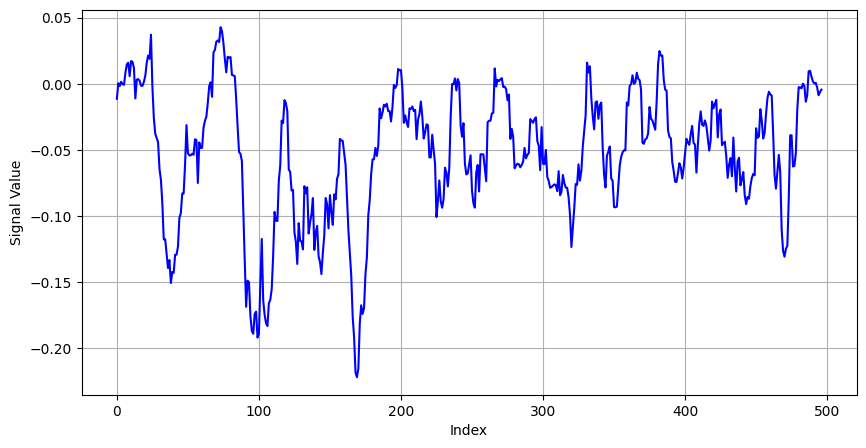

AI text signal


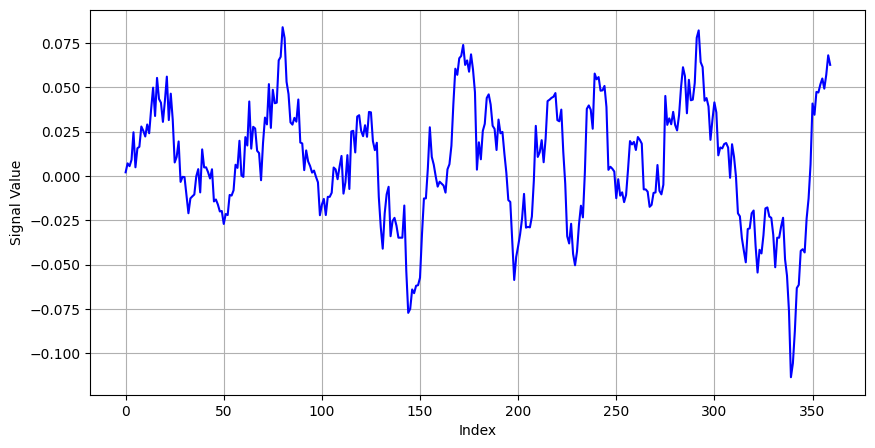

In [149]:
print("Human text signal")
human_text = train_df.filter(pl.col("label") == 0)[0, "text"]
human_signal = get_signal(human_text)
plot_signal(human_signal, smoothing_factor=5)

print("AI text signal")
ai_text = train_df.filter(pl.col("label") == 1)[0, "text"]
ai_signal = get_signal(ai_text)
plot_signal(ai_signal, smoothing_factor=5)

Human text signal: 513


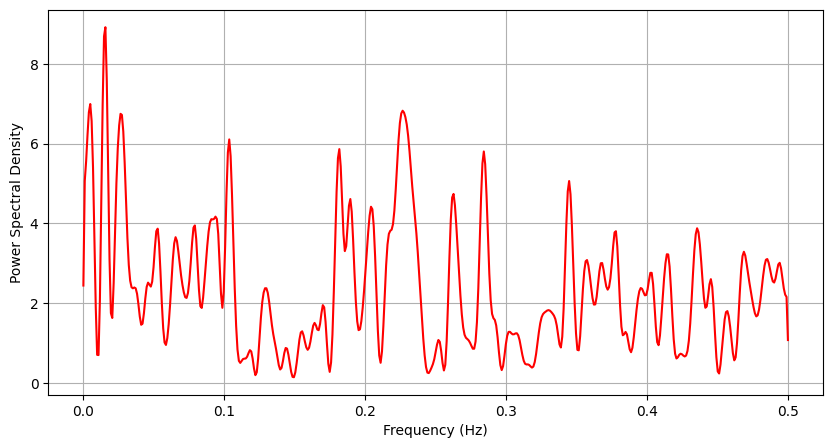

AI text signal: 513


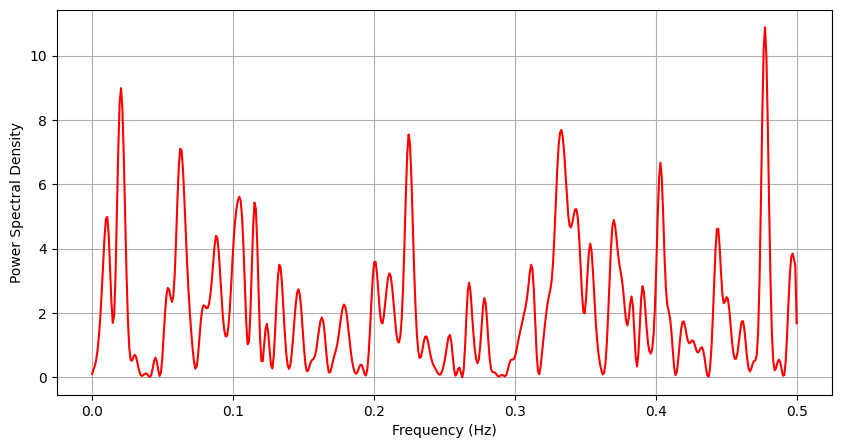

In [150]:
f, Pxx = compute_periodogram(human_signal)
print(f"Human text signal: {len(Pxx)}")
plot_periodogram(f, Pxx)

f, Pxx = compute_periodogram(ai_signal)
print(f"AI text signal: {len(Pxx)}")
plot_periodogram(f, Pxx)

In [151]:
periodograms = []

for row in tqdm(train_df.iter_rows(named=True), total=len(train_df)):
    text = row["text"]
    label = row["label"]
    signal = get_signal(text)
    nperseg = min(len(signal), 256)
    frequencies, power_density = compute_periodogram(signal, nperseg=nperseg)
    periodograms.append({"frequencies": frequencies.tolist(), "power_density": power_density.tolist(), "label": label})

len(periodograms)

100%|██████████| 23707/23707 [06:36<00:00, 59.78it/s]


23707

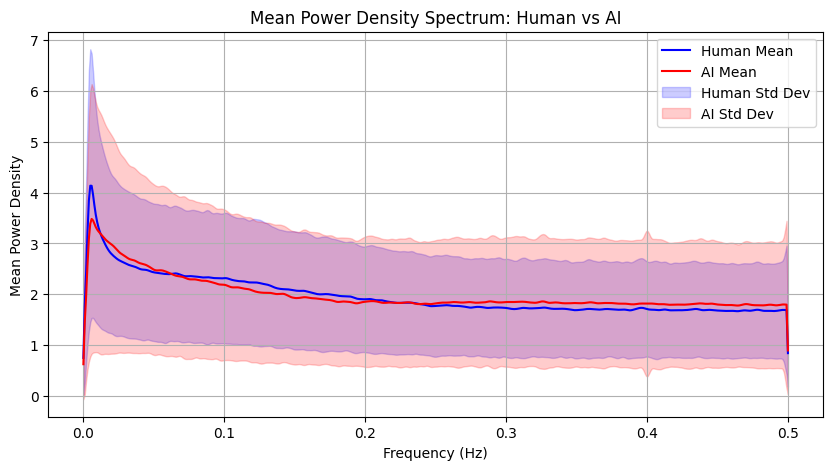

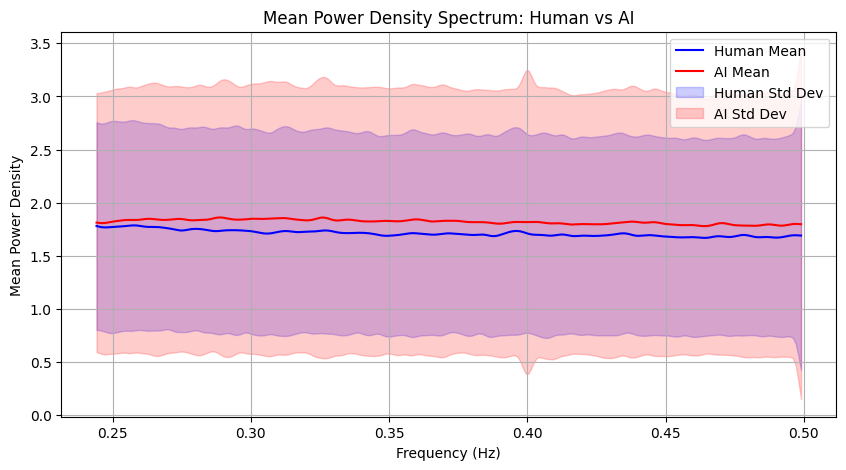

In [158]:
human_periodograms = [p["power_density"] for p in periodograms if p["label"] == 0]
mean_human_power_density = np.mean(human_periodograms, axis=0)
std_human_power_density = np.std(human_periodograms, axis=0)

ai_periodograms = [p["power_density"] for p in periodograms if p["label"] == 1]
mean_ai_power_density = np.mean(ai_periodograms, axis=0)
std_ai_power_density = np.std(ai_periodograms, axis=0)

plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, std_ai=std_ai_power_density, std_human=std_human_power_density)
plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, begin=250, end=-1, std_ai=std_ai_power_density, std_human=std_human_power_density)

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = [p["power_density"][250:-1] for p in periodograms]
y = [p["label"] for p in periodograms]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6421341206242092
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.28      0.38      1856
           1       0.65      0.87      0.75      2886

    accuracy                           0.64      4742
   macro avg       0.62      0.58      0.57      4742
weighted avg       0.63      0.64      0.61      4742

